## <b>01<span style='color:#e61427'>|</span> Importing Libraries </b>

In [1]:
# Importing necessary libraries for deep learning, image processing, and data handling

import os  # Interact with the operating system (file and directory manipulation)
import shutil  # High-level file operations like copying, moving, and removing
import itertools  # Tools for efficient looping and combinatorics
import pathlib  # For working with file and directory paths
from collections import Counter  # Utility for counting elements in an iterable
import hashlib

import numpy as np  # Array manipulation and mathematical operations
import pandas as pd  # Data manipulation and analysis using dataframes
import matplotlib.pyplot as plt  # For creating static, animated, and interactive visualizations
import seaborn as sns  # Enhanced data visualization (built on top of Matplotlib)
sns.set(style='darkgrid')  # Set Seaborn's default theme for plots

from PIL import Image  # Open, manipulate, and save images
import cv2  # OpenCV for advanced image processing

import torch  # Main PyTorch library for tensor operations
import torch.nn as nn  # Provides modules for defining neural network layers
import torch.optim as optim  # Optimizers for model training (e.g., SGD, Adam)
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Reduce learning rate when a metric plateaus
import torch.nn.functional as F  # Importing PyTorch's functional API, aliased as 'F'

import torchvision  # Core library for image-based models and datasets
import torchvision.transforms as transforms  # Image transformations (e.g., resizing, normalizing)

from torchsummary import summary  # Display a summary of the neural network architecture
import splitfolders  # Split image dataset folders into train, validation, and test sets

from tqdm.notebook import tqdm  # Progress bars for loops and tracking long-running tasks

from sklearn.metrics import confusion_matrix, classification_report  # Generate evaluation metrics like confusion matrix and classification report

# Libraries for explainability methods (model interpretation)
import shap  # SHAP values for model interpretability
from lime import lime_image  # LIME for image explanation
from skimage.segmentation import mark_boundaries  # Segmentation utility for marking boundaries in image explanations

# Captum library for model interpretability in PyTorch
from captum.attr import IntegratedGradients, Occlusion  # Attribution methods from Captum

# Visualization tools for explainability
import matplotlib.patches as mpatches  # Drawing shapes on visualizations



## <b>02<span style='color:#e61227'>|</span> Selection of Dataset and Exploratory Data Analysis </b>

#### <b><span style='color:#e61227'>|</span> Load dataset </b>

In [2]:
# Read the CSV file and load it into a pandas DataFrame
df = pd.read_csv('Dataset/metadata.csv')

# Print the first five rows of the DataFrame in Markdown table format
print(df.head().to_markdown())

|    |   Unnamed: 0 | image           | class   | format   | mode   | shape         |
|---:|-------------:|:----------------|:--------|:---------|:-------|:--------------|
|  0 |            0 | Cancer (1).jpg  | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  1 |            1 | Cancer (1).png  | tumor   | PNG      | L      | (300, 240)    |
|  2 |            2 | Cancer (1).tif  | tumor   | TIFF     | RGB    | (256, 256, 3) |
|  3 |            3 | Cancer (10).jpg | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  4 |            4 | Cancer (10).tif | tumor   | TIFF     | RGB    | (256, 256, 3) |


In [3]:
# Count the occurrences of each unique value in the 'format' column
format_counts = df['format'].value_counts()

# Print the counts for each format
print(format_counts)


format
JPEG    4496
TIFF      86
PNG       18
Name: count, dtype: int64


In [4]:
# Count the occurrences of each unique value in the 'mode' column
mode_counts = df['mode'].value_counts()

# Print the counts for each mode
print(mode_counts)


mode
RGB     4461
L        132
RGBA       5
P          2
Name: count, dtype: int64


In [5]:
# Group the DataFrame by 'class' and 'format', then count the occurrences of each combination
class_format_counts = df.groupby(['class', 'format']).size().reset_index(name='count')

# Print the resulting DataFrame showing the distribution of 'class' and 'format'
print(class_format_counts)


    class format  count
0  normal   JPEG   2078
1  normal    PNG      9
2   tumor   JPEG   2418
3   tumor    PNG      9
4   tumor   TIFF     86


In [6]:
# Group the DataFrame by 'class' and 'mode', then count the occurrences of each combination
class_mode_counts = df.groupby(['class', 'mode']).size().reset_index(name='count')

# Print the resulting DataFrame showing the distribution of 'class' and 'mode'
print(class_mode_counts)


    class  mode  count
0  normal     L     40
1  normal     P      2
2  normal   RGB   2040
3  normal  RGBA      5
4   tumor     L     92
5   tumor   RGB   2421


In [7]:

# Group the DataFrame by 'class', 'format', and 'shape', then count the occurrences of each combination
class_format_shape_counts = df.groupby(['class', 'format', 'shape']).size().reset_index(name='count')

# Print the resulting DataFrame showing the distribution of 'class', 'format', and 'shape'
print(class_format_shape_counts)


      class format            shape  count
0    normal   JPEG     (1024, 1024)      3
1    normal   JPEG  (1024, 1024, 3)      3
2    normal   JPEG   (1075, 890, 3)      2
3    normal   JPEG  (1446, 1375, 3)      1
4    normal   JPEG    (168, 300, 3)     52
..      ...    ...              ...    ...
483   tumor   JPEG    (938, 911, 3)     18
484   tumor   JPEG    (960, 781, 3)     15
485   tumor   JPEG    (993, 825, 3)      7
486   tumor    PNG       (300, 240)      9
487   tumor   TIFF    (256, 256, 3)     86

[488 rows x 4 columns]


In [8]:
# List the contents of the 'Dataset/Brain Tumor Data Set' directory
directory_contents = os.listdir('Dataset/Brain Tumor Data Set')

# Print the contents of the directory
print(directory_contents)


['Brain Tumor', 'Healthy']


#### <b><span style='color:#e61227'>|</span> Preprocessing dataset </b>

In [9]:
# Define the source directory and destination directory
source_folder = 'Dataset\\Brain Tumor Data Set'  # Source folder
destination_folder = 'Dataset\\Data for processing'  # Destination folder

# Check if the source folder exists
if os.path.exists(source_folder):
    # Check if the destination folder exists
    if os.path.exists(destination_folder):
        # If the destination folder exists, remove it
        shutil.rmtree(destination_folder)
        print(f"Destination folder '{destination_folder}' already existed and was removed.")
    
    # Copy the source folder and its contents to the destination folder
    shutil.copytree(source_folder, destination_folder)
    print(f"Copied '{source_folder}' and renamed it as '{destination_folder}'.")
else:
    # If the source folder does not exist, notify the user
    print(f"The source folder '{source_folder}' does not exist.")

# Print message to indicate that the process is complete
print("Processing complete.")


Copied 'Dataset\Brain Tumor Data Set' and renamed it as 'Dataset\Data for processing'.
Processing complete.


In [10]:
# Define the folder where files need to be processed
folder_to_process = 'Dataset/Data for processing'  # Folder containing files for processing

# Walk through the directory and check each file
for root, dirs, files in os.walk(folder_to_process):
    for filename in files:
        # Construct the full file path
        file_path = os.path.join(root, filename)
        
        try:
            # Open the image and check its mode (RGB or non-RGB)
            with Image.open(file_path) as img:
                # If the image is not in RGB mode, mark it for removal
                if img.mode != 'RGB':
                    print(f"{filename} is not in RGB mode")
                    to_remove = True
                else:
                    to_remove = False  # Do not remove if the image is in RGB mode
        except Exception as e:
            # If an error occurs while processing the image, mark it for removal
            print(f"Error processing {filename}: {e}")
            to_remove = True  # Mark file for deletion if it couldn't be opened

        # Remove the file if it is marked for deletion
        if to_remove:
            try:
                os.remove(file_path)
                print(f"Removed {filename}")
            except Exception as e:
                # Handle any errors that occur during file removal
                print(f"Error removing {filename}: {e}")

# Indicate that the processing is complete
print("Processing complete. Only RGB mode files are kept.")


Cancer (1).png is not in RGB mode
Removed Cancer (1).png
Cancer (1028).jpg is not in RGB mode
Removed Cancer (1028).jpg
Cancer (1209).jpg is not in RGB mode
Removed Cancer (1209).jpg
Cancer (1236).jpg is not in RGB mode
Removed Cancer (1236).jpg
Cancer (1258).jpg is not in RGB mode
Removed Cancer (1258).jpg
Cancer (1263).jpg is not in RGB mode
Removed Cancer (1263).jpg
Cancer (1266).jpg is not in RGB mode
Removed Cancer (1266).jpg
Cancer (1271).jpg is not in RGB mode
Removed Cancer (1271).jpg
Cancer (1282).jpg is not in RGB mode
Removed Cancer (1282).jpg
Cancer (1401).jpg is not in RGB mode
Removed Cancer (1401).jpg
Cancer (1404).jpg is not in RGB mode
Removed Cancer (1404).jpg
Cancer (1424).jpg is not in RGB mode
Removed Cancer (1424).jpg
Cancer (1448).jpg is not in RGB mode
Removed Cancer (1448).jpg
Cancer (1454).jpg is not in RGB mode
Removed Cancer (1454).jpg
Cancer (1458).jpg is not in RGB mode
Removed Cancer (1458).jpg
Cancer (1463).jpg is not in RGB mode
Removed Cancer (1463).jp

In [11]:
# Define the folders to check for images
brain_tumor_folder = 'Dataset/Data for processing/Brain Tumor'
healthy_folder = 'Dataset/Data for processing/Healthy'

# Helper function to calculate the MD5 hash of a file
def calculate_md5(file_path, block_size=65536):
    hash_md5 = hashlib.md5()
    with open(file_path, 'rb') as f:
        for block in iter(lambda: f.read(block_size), b''):
            hash_md5.update(block)
    return hash_md5.hexdigest()

# Function to check for duplicate images in a folder
def check_duplicates(folder_path):
    duplicates = []
    hashes = {}
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    for filename in image_files:
        file_path = os.path.join(folder_path, filename)

        try:
            # Calculate the MD5 hash
            file_hash = calculate_md5(file_path)
            if file_hash in hashes:
                duplicates.append((file_path, hashes[file_hash]))
            else:
                hashes[file_hash] = file_path
        except Exception as e:
            print(f"Error processing {filename}: {e}")
    
    return duplicates

# Check duplicates in Brain Tumor folder
brain_tumor_duplicates = check_duplicates(brain_tumor_folder)
print(f"Brain Tumor Folder - Total Duplicates: {len(brain_tumor_duplicates)}")
for dup in brain_tumor_duplicates:
    print(f"Duplicate: {dup[0]} is a duplicate of {dup[1]}")

# Check duplicates in Healthy folder
healthy_duplicates = check_duplicates(healthy_folder)
print(f"\nHealthy Folder - Total Duplicates: {len(healthy_duplicates)}")
for dup in healthy_duplicates:
    print(f"Duplicate: {dup[0]} is a duplicate of {dup[1]}")

# Print summary
total_duplicates = len(brain_tumor_duplicates) + len(healthy_duplicates)
print(f"\nTotal duplicate images across both folders: {total_duplicates}")


Brain Tumor Folder - Total Duplicates: 192
Duplicate: Dataset/Data for processing/Brain Tumor\Cancer (1081).jpg is a duplicate of Dataset/Data for processing/Brain Tumor\Cancer (1006).jpg
Duplicate: Dataset/Data for processing/Brain Tumor\Cancer (1089).jpg is a duplicate of Dataset/Data for processing/Brain Tumor\Cancer (1035).jpg
Duplicate: Dataset/Data for processing/Brain Tumor\Cancer (184).jpg is a duplicate of Dataset/Data for processing/Brain Tumor\Cancer (162).jpg
Duplicate: Dataset/Data for processing/Brain Tumor\Cancer (2).jpg is a duplicate of Dataset/Data for processing/Brain Tumor\Cancer (126).jpg
Duplicate: Dataset/Data for processing/Brain Tumor\Cancer (2218).jpg is a duplicate of Dataset/Data for processing/Brain Tumor\Cancer (1033).jpg
Duplicate: Dataset/Data for processing/Brain Tumor\Cancer (2224).jpg is a duplicate of Dataset/Data for processing/Brain Tumor\Cancer (1034).jpg
Duplicate: Dataset/Data for processing/Brain Tumor\Cancer (2225).jpg is a duplicate of Datase

In [12]:
# Function to remove duplicate images in a folder
def remove_duplicates(folder_path):
    duplicates = []
    hashes = {}
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    for filename in image_files:
        file_path = os.path.join(folder_path, filename)

        try:
            # Calculate the MD5 hash
            file_hash = calculate_md5(file_path)
            if file_hash in hashes:
                duplicates.append(file_path)  # Add the duplicate file to the list
            else:
                hashes[file_hash] = file_path
        except Exception as e:
            print(f"Error processing {filename}: {e}")

    # Remove duplicate files
    for dup in duplicates:
        try:
            os.remove(dup)  # Remove the duplicate file
            print(f"Removed duplicate file: {dup}")
        except Exception as e:
            print(f"Error removing file {dup}: {e}")

    return len(duplicates)

# Function to count the images in a folder
def count_images(folder_path):
    return len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

# Remove duplicates and print the number of images in each folder

# Brain Tumor Folder
print("Processing Brain Tumor Folder...")
brain_tumor_duplicates_removed = remove_duplicates(brain_tumor_folder)
brain_tumor_count = count_images(brain_tumor_folder)
print(f"Brain Tumor Folder - Duplicates Removed: {brain_tumor_duplicates_removed}")
print(f"Brain Tumor Folder - Total Images Remaining: {brain_tumor_count}")

# Healthy Folder
print("\nProcessing Healthy Folder...")
healthy_duplicates_removed = remove_duplicates(healthy_folder)
healthy_count = count_images(healthy_folder)
print(f"Healthy Folder - Duplicates Removed: {healthy_duplicates_removed}")
print(f"Healthy Folder - Total Images Remaining: {healthy_count}")


Processing Brain Tumor Folder...
Removed duplicate file: Dataset/Data for processing/Brain Tumor\Cancer (1081).jpg
Removed duplicate file: Dataset/Data for processing/Brain Tumor\Cancer (1089).jpg
Removed duplicate file: Dataset/Data for processing/Brain Tumor\Cancer (184).jpg
Removed duplicate file: Dataset/Data for processing/Brain Tumor\Cancer (2).jpg
Removed duplicate file: Dataset/Data for processing/Brain Tumor\Cancer (2218).jpg
Removed duplicate file: Dataset/Data for processing/Brain Tumor\Cancer (2224).jpg
Removed duplicate file: Dataset/Data for processing/Brain Tumor\Cancer (2225).jpg
Removed duplicate file: Dataset/Data for processing/Brain Tumor\Cancer (2249).jpg
Removed duplicate file: Dataset/Data for processing/Brain Tumor\Cancer (2258).jpg
Removed duplicate file: Dataset/Data for processing/Brain Tumor\Cancer (2259).jpg
Removed duplicate file: Dataset/Data for processing/Brain Tumor\Cancer (2261).jpg
Removed duplicate file: Dataset/Data for processing/Brain Tumor\Cance

In [13]:
# Function to check for corrupted images
def check_corrupted_images(folder_path):
    corrupted_images = []
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    for filename in image_files:
        file_path = os.path.join(folder_path, filename)

        try:
            # Attempt to open the image
            with Image.open(file_path) as img:
                img.verify()  # Check for corruption
        except Exception as e:
            corrupted_images.append(file_path)
            print(f"Error processing {filename}: {e}")
    
    return corrupted_images

# Check corrupted images in Brain Tumor folder
brain_tumor_corrupted = check_corrupted_images(brain_tumor_folder)
print("Brain Tumor Folder - Corrupted Images:")
for corrupted in brain_tumor_corrupted:
    print(f"Corrupted: {corrupted}")

# Check corrupted images in Healthy folder
healthy_corrupted = check_corrupted_images(healthy_folder)
print("\nHealthy Folder - Corrupted Images:")
for corrupted in healthy_corrupted:
    print(f"Corrupted: {corrupted}")


Brain Tumor Folder - Corrupted Images:

Healthy Folder - Corrupted Images:


In [14]:
# Function to check if an image is blank (all pixels the same)
def is_blank_image(img):
    img_gray = img.convert("L")  # Convert to grayscale
    return not ImageChops.difference(img_gray, Image.new(img_gray.mode, img_gray.size, img_gray.getpixel((0, 0)))).getbbox()

# Function to check for blank images in a folder
def check_blank_images(folder_path):
    blank_images = []
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    for filename in image_files:
        file_path = os.path.join(folder_path, filename)

        try:
            # Open the image and check if it's blank
            with Image.open(file_path) as img:
                if is_blank_image(img):
                    blank_images.append(file_path)
        except Exception as e:
            print(f"Error processing {filename}: {e}")
    
    return blank_images

# Check blank images in Brain Tumor folder
brain_tumor_blank = check_blank_images(brain_tumor_folder)
print("Brain Tumor Folder - Blank Images:")
for blank in brain_tumor_blank:
    print(f"Blank: {blank}")

# Check blank images in Healthy folder
healthy_blank = check_blank_images(healthy_folder)
print("\nHealthy Folder - Blank Images:")
for blank in healthy_blank:
    print(f"Blank: {blank}")


Error processing Cancer (1).jpg: name 'ImageChops' is not defined
Error processing Cancer (1).tif: name 'ImageChops' is not defined
Error processing Cancer (10).jpg: name 'ImageChops' is not defined
Error processing Cancer (10).tif: name 'ImageChops' is not defined
Error processing Cancer (100).jpg: name 'ImageChops' is not defined
Error processing Cancer (1000).jpg: name 'ImageChops' is not defined
Error processing Cancer (1001).jpg: name 'ImageChops' is not defined
Error processing Cancer (1002).JPG: name 'ImageChops' is not defined
Error processing Cancer (1003).jpg: name 'ImageChops' is not defined
Error processing Cancer (1004).jpg: name 'ImageChops' is not defined
Error processing Cancer (1005).jpg: name 'ImageChops' is not defined
Error processing Cancer (1006).jpg: name 'ImageChops' is not defined
Error processing Cancer (1007).jpg: name 'ImageChops' is not defined
Error processing Cancer (1008).jpg: name 'ImageChops' is not defined
Error processing Cancer (1009).jpg: name 'Ima

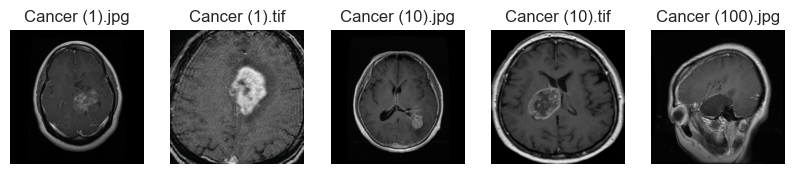

In [15]:
# Get the list of image files from the folder
image_files = [f for f in os.listdir(brain_tumor_folder) if os.path.isfile(os.path.join(brain_tumor_folder, f))]

# Set the number of images you want to display
num_images_to_show = 5  # Change this to the number of images you want to visualize

# Loop through the images and visualize them
plt.figure(figsize=(10, 10))  # Set the figure size
for i, image_name in enumerate(image_files[:num_images_to_show]):
    img_path = os.path.join(brain_tumor_folder, image_name)
    
    try:
        # Open the image
        img = Image.open(img_path)
        
        # Display the image in the plot
        plt.subplot(1, num_images_to_show, i + 1)
        plt.imshow(img)
        plt.title(image_name)
        plt.axis('off')  # Turn off the axes for clarity
    except Exception as e:
        print(f"Error loading image {image_name}: {e}")

plt.show()


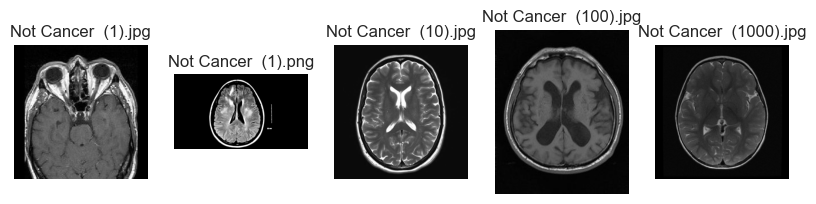

In [16]:
# Get the list of image files from the folder
image_files = [f for f in os.listdir(healthy_folder) if os.path.isfile(os.path.join(healthy_folder, f))]

# Set the number of images you want to display
num_images_to_show = 5  # Change this to the number of images you want to visualize

# Loop through the images and visualize them
plt.figure(figsize=(10, 10))  # Set the figure size
for i, image_name in enumerate(image_files[:num_images_to_show]):
    img_path = os.path.join(healthy_folder, image_name)
    
    try:
        # Open the image
        img = Image.open(img_path)
        
        # Display the image in the plot
        plt.subplot(1, num_images_to_show, i + 1)
        plt.imshow(img)
        plt.title(image_name)
        plt.axis('off')  # Turn off the axes for clarity
    except Exception as e:
        print(f"Error loading image {image_name}: {e}")

plt.show()


In [17]:
# Define the folders where files need to be processed
folder_to_process = 'Dataset/Data for processing'
destination_folder = 'Dataset/all_images'  # New folder for RGB images
healthy_folder = 'Dataset/Data for processing/Healthy'
tumor_folder = 'Dataset/Data for processing/Brain Tumor'

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)
    print(f"Created destination folder: {destination_folder}")

# Initialize counters for RGB files
rgb_file_count = 0

# Walk through the directory structure and process each file
for root, dirs, files in os.walk(folder_to_process):
    for filename in files:
        # Construct the full path to the file
        file_path = os.path.join(root, filename)
        
        try:
            # Open the image and check its mode
            with Image.open(file_path) as img:
                if img.mode == 'RGB':
                    # If the image is in RGB mode, copy it to the destination folder
                    dest_path = os.path.join(destination_folder, filename)
                    shutil.copy(file_path, dest_path)
                    rgb_file_count += 1
                    print(f"Copied {filename} to {destination_folder}")
                else:
                    print(f"{filename} is not in RGB mode and will not be copied.")
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Function to count the number of files in a folder
def count_files(folder_path):
    return len([file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))])

# Count files in destination folder, Healthy, and Brain Tumor folders
rgb_count = count_files(destination_folder)
healthy_count = count_files(healthy_folder)
tumor_count = count_files(tumor_folder)

# Print file counts
print(f"\nProcessing complete.")
print(f"Total RGB files copied to {destination_folder}: {rgb_count}")
print(f"Total files in {healthy_folder}: {healthy_count}")
print(f"Total files in {tumor_folder}: {tumor_count}")


Created destination folder: Dataset/all_images
Copied Cancer (1).jpg to Dataset/all_images
Copied Cancer (1).tif to Dataset/all_images
Copied Cancer (10).jpg to Dataset/all_images
Copied Cancer (10).tif to Dataset/all_images
Copied Cancer (100).jpg to Dataset/all_images
Copied Cancer (1000).jpg to Dataset/all_images
Copied Cancer (1001).jpg to Dataset/all_images
Copied Cancer (1002).JPG to Dataset/all_images
Copied Cancer (1003).jpg to Dataset/all_images
Copied Cancer (1004).jpg to Dataset/all_images
Copied Cancer (1005).jpg to Dataset/all_images
Copied Cancer (1006).jpg to Dataset/all_images
Copied Cancer (1007).jpg to Dataset/all_images
Copied Cancer (1008).jpg to Dataset/all_images
Copied Cancer (1009).jpg to Dataset/all_images
Copied Cancer (101).jpg to Dataset/all_images
Copied Cancer (1010).jpg to Dataset/all_images
Copied Cancer (1011).jpg to Dataset/all_images
Copied Cancer (1012).JPG to Dataset/all_images
Copied Cancer (1013).JPG to Dataset/all_images
Copied Cancer (1014).jpg 

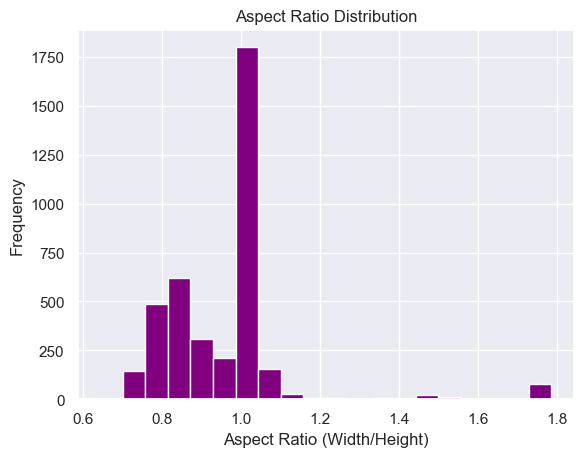

In [18]:
# Define the folder to check for images
all_images_folder = 'Dataset/all_images'

# Aspect Ratio Analysis
# Calculate the aspect ratio of each image and plot the distribution.
aspect_ratios = []

# Loop through each image in the 'all_images' folder
for filename in os.listdir(all_images_folder):
    img_path = os.path.join(all_images_folder, filename)
    
    # Check if the file is an image (based on file extension)
    if filename.endswith(('jpg', 'jpeg', 'png', 'tiff', 'tif')):
        try:
            # Open the image and calculate its aspect ratio
            with Image.open(img_path) as img:
                width, height = img.size
                
                # Ensure the height is non-zero to avoid division by zero
                if height > 0:
                    aspect_ratios.append(width / height)
                else:
                    print(f"Skipping {img_path}: Height is zero.")
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

# Plot the aspect ratio distribution if we have valid data
if aspect_ratios:
    plt.hist(aspect_ratios, bins=20, color='purple')
    plt.title('Aspect Ratio Distribution')
    plt.xlabel('Aspect Ratio (Width/Height)')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("No valid aspect ratios to plot.")


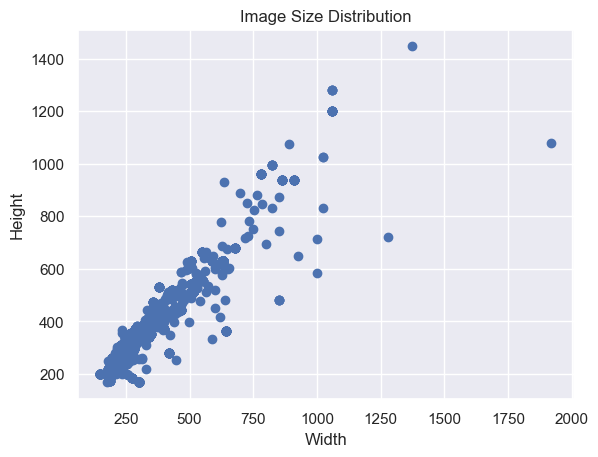

In [19]:
# Image Size Distribution
# Analyze the dimensions of each image and plot the distribution of widths and heights.
# Define the folder to check for images
all_images_folder = 'Dataset/all_images'

image_sizes = []

# Loop through each image in the 'all_images' folder
for filename in os.listdir(all_images_folder):
    img_path = os.path.join(all_images_folder, filename)


for filename in os.listdir(all_images_folder):
    img_path = os.path.join(all_images_folder, filename)
    img = Image.open(img_path)
    width, height = img.size
    image_sizes.append((width, height))

# Separate the widths and heights for plotting
widths = [size[0] for size in image_sizes]
heights = [size[1] for size in image_sizes]

# Plot width and height distributions
plt.scatter(widths, heights)
plt.title('Image Size Distribution')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

In [20]:
# Path to your images folder
all_images_folder = 'Dataset/all_images'

# To store all pixel intensities
all_pixels = []

# Iterate through all images in the folder
for filename in os.listdir(all_images_folder):
    img_path = os.path.join(all_images_folder, filename)
    
    # Open the image
    img = Image.open(img_path)
    
    # Convert image to grayscale to compute pixel intensities
    grayscale_img = img.convert('L')  # 'L' mode is for grayscale
    
    # Get pixel data and flatten it
    pixel_data = np.array(grayscale_img).flatten()
    all_pixels.extend(pixel_data)

# Convert all pixel data to numpy array for statistical analysis
all_pixels = np.array(all_pixels)

# Compute statistics for pixel intensities
mean_pixel_value = np.mean(all_pixels)
std_pixel_value = np.std(all_pixels)
min_pixel_value = np.min(all_pixels)
max_pixel_value = np.max(all_pixels)

# Print the statistical summary
print(f"Mean Pixel Intensity: {mean_pixel_value}")
print(f"Standard Deviation of Pixel Intensity: {std_pixel_value}")
print(f"Minimum Pixel Intensity: {min_pixel_value}")
print(f"Maximum Pixel Intensity: {max_pixel_value}")


Mean Pixel Intensity: 56.92600767934666
Standard Deviation of Pixel Intensity: 63.687183659214334
Minimum Pixel Intensity: 0
Maximum Pixel Intensity: 255


#### <b><span style='color:#e61227'>|</span> Split dataset </b>

In [21]:
# Dataset Path
data_dir = 'Dataset/Data for processing'
data_dir = pathlib.Path(data_dir)

# Splitting dataset to train_set, and test_set
splitfolders.ratio(data_dir, output='Dataset/Working data', seed=20, ratio=(0.7, 0.3))


# New dataset path
data_dir = 'Dataset/Working data'
data_dir = pathlib.Path(data_dir)

Copying files: 3943 files [00:04, 826.57 files/s] 


In [22]:
# Define the root folder to count files in
folder_to_process = 'Dataset/Working data'

# Traverse the directory structure and count files in each subdirectory
for root, dirs, files in os.walk(folder_to_process):
    # Only print the count for directories (subdirectories)
    if len(files) > 0:
        print(f"Directory: {root}")
        print(f"Number of files: {len(files)}\n")


Directory: Dataset/Working data\train\Brain Tumor
Number of files: 1560

Directory: Dataset/Working data\train\Healthy
Number of files: 1199

Directory: Dataset/Working data\val\Brain Tumor
Number of files: 669

Directory: Dataset/Working data\val\Healthy
Number of files: 515



#### <b><span style='color:#e61227'>|</span> Image Transformation </b>

In [23]:
# Define a set of transformations for image preprocessing
transform = transforms.Compose([
    # Resize the image to 256x256 pixels
    transforms.Resize((256, 256)),
    
    # Apply random horizontal flip with a probability of 50%
    transforms.RandomHorizontalFlip(p=0.5),
    
    # Apply random vertical flip with a probability of 50%
    transforms.RandomVerticalFlip(p=0.5),
    
    # Apply random rotation within a range of -30 to +30 degrees
    transforms.RandomRotation(30),
    
    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
    
    # Normalize the image using the mean and standard deviation values for each channel (RGB)
    # These values are commonly used for pre-trained models like ResNet.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


Here's a breakdown of why each transformation is used:

transforms.Resize((256, 256)):
    Purpose: Ensures that all input images are resized to a uniform size of 256x256 pixels, which is essential because neural networks require fixed-size inputs.

transforms.RandomHorizontalFlip(p=0.5):
    Purpose: Randomly flips the image horizontally with a probability of 50%. This is a data augmentation technique to help the model generalize better by learning from multiple variations of the same image (e.g., flipping a cat's picture would not change the fact it's still a cat).

transforms.RandomVerticalFlip(p=0.5):
    Purpose: Similar to the horizontal flip, this randomly flips the image vertically with a 50% probability. This adds more variety to the training data, especially useful in cases where vertical symmetry doesn't change the label (e.g., in medical or satellite images).

transforms.RandomRotation(30):
    Purpose: Randomly rotates the image by up to 30 degrees. This further helps with data augmentation, making the model more robust to variations in orientation.

transforms.ToTensor():
    Purpose: Converts the image from a PIL (Python Imaging Library) format to a PyTorch tensor, which is the format required by PyTorch models. It also scales the pixel values from the range [0, 255] to [0, 1].

transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    Purpose: Normalizes the image using the mean and standard deviation of the ImageNet dataset. Pretrained models, like those trained on ImageNet, expect inputs to have these specific mean and standard deviation values. This step standardizes the input data, making it easier for the network to learn effectively.

In [24]:
# Define the training dataset using the ImageFolder class from torchvision. 
# 'data_dir.joinpath("train")' points to the directory containing training images. 
# The 'transform' argument is applied to preprocess the images (e.g., resizing, normalization).
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath("train"), transform=transform)

# Accessing and verifying the transformations applied to the training dataset. 
# This could be useful for debugging or logging purposes.
train_set.transform

# Define the validation (test) dataset using the ImageFolder class.
# 'data_dir.joinpath("val")' points to the directory containing validation images.
# The same 'transform' argument is applied for consistency in image preprocessing.
test_set = torchvision.datasets.ImageFolder(data_dir.joinpath("val"), transform=transform)

# Accessing and verifying the transformations applied to the validation dataset.
test_set.transform


Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

#### <b><span style='color:#e61227'>|</span> Data Analysis and Visualisation </b>

##### <b><I> Dataset Dimensions and Shape </I></b>

In [25]:
# Checking dimensions of a random image from the training set
# Access the 101st image and its corresponding label from the training dataset.
img, label = train_set[100]

# Print the shape of the image tensor.
# This will provide the dimensions (C x H x W) where C is the number of channels (e.g., 3 for RGB), 
# H is the height, and W is the width of the image.
print(f"Image shape: {img.shape}")



Image shape: torch.Size([3, 256, 256])


In [26]:
# Checking dimensions of a random image from the validation (test) set
# Access the 101st image and its corresponding label from the validation dataset.
img, label = test_set[100]

# Print the shape of the image tensor.
# The shape is expected to be (C x H x W), where:
# C: Number of channels (e.g., 3 for RGB images),
# H: Height of the image, 
# W: Width of the image.
print(f"Image shape: {img.shape}")



Image shape: torch.Size([3, 256, 256])


##### <b><I> Class Distribution (Frequency of Labels) </I></b> 

Class distribution in Train Set:
Brain Tumor: 1560 images
Healthy: 1199 images


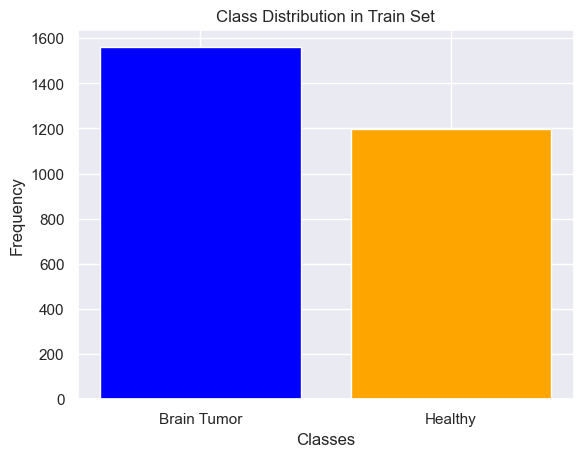

Class distribution in Test Set:
Brain Tumor: 669 images
Healthy: 515 images


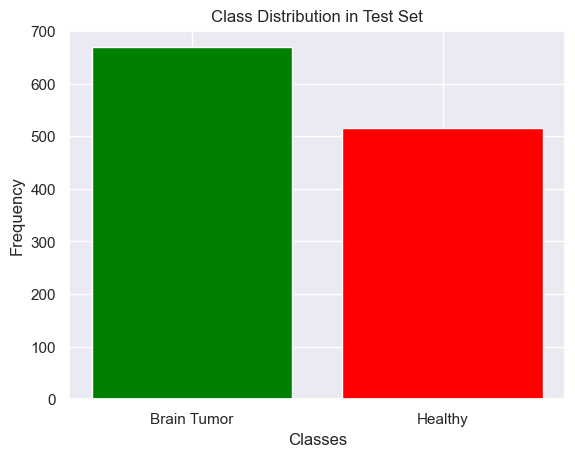

In [27]:
# Define the class labels
CLA_label = {
    0: 'Brain Tumor',
    1: 'Healthy'
}

# Extract labels from the training set
labels_train = [label for _, label in train_set]
label_count_train = Counter(labels_train)

# Display the count of each label in the training set
print("Class distribution in Train Set:")
for label, count in label_count_train.items():
    print(f"{CLA_label[label]}: {count} images")

# Plot the class distribution for the training set
plt.bar(CLA_label.values(), label_count_train.values(), color=['blue', 'orange'])
plt.title('Class Distribution in Train Set')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.show()

# Extract labels from the validation/test set
labels_test = [label for _, label in test_set]
label_count_test = Counter(labels_test)

# Display the count of each label in the test set
print("Class distribution in Test Set:")
for label, count in label_count_test.items():
    print(f"{CLA_label[label]}: {count} images")

# Plot the class distribution for the test set
plt.bar(CLA_label.values(), label_count_test.values(), color=['green', 'red'])
plt.title('Class Distribution in Test Set')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.show()


##### <b><I> Aspect Ratio Analysis </I></b> 

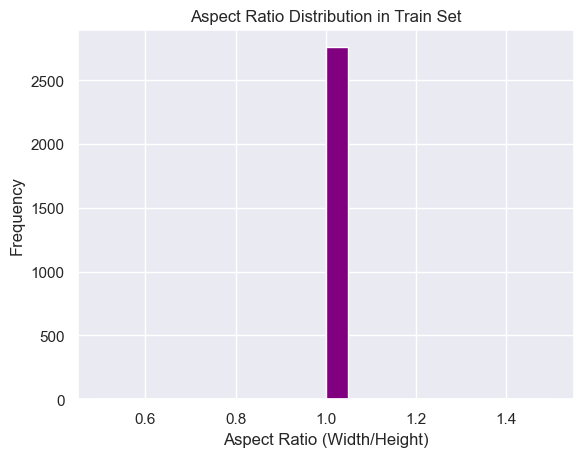

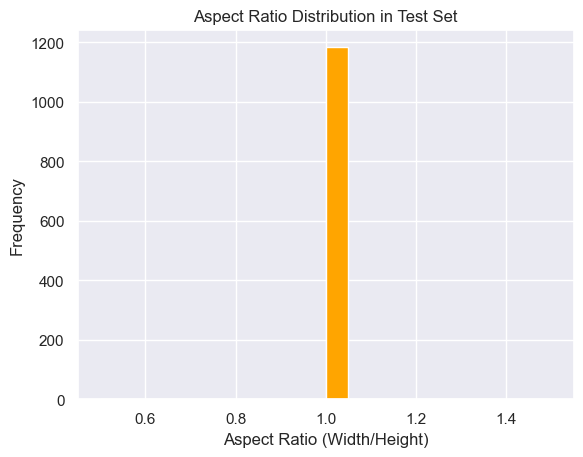

In [28]:
# Check aspect ratios of images in the train set
aspect_ratios_train = [img.shape[1] / img.shape[2] for img, _ in train_set]

# Plot the aspect ratio distribution for the train set
plt.hist(aspect_ratios_train, bins=20, color='purple')
plt.title('Aspect Ratio Distribution in Train Set')
plt.xlabel('Aspect Ratio (Width/Height)')
plt.ylabel('Frequency')
plt.show()

# Check aspect ratios of images in the test set
aspect_ratios_test = [img.shape[1] / img.shape[2] for img, _ in test_set]

# Plot the aspect ratio distribution for the test set
plt.hist(aspect_ratios_test, bins=20, color='orange')
plt.title('Aspect Ratio Distribution in Test Set')
plt.xlabel('Aspect Ratio (Width/Height)')
plt.ylabel('Frequency')
plt.show()



##### <b><I> Corrupt or Blank Images </I></b> 

In [29]:
# Function to identify corrupt or blank images in a dataset
def find_corrupt_images(dataset):
    corrupt_images = []
    for i in range(len(dataset)):
        img, label = dataset[i]
        if img.mean() == 0 or img.std() == 0:  # Blank or near-blank image
            corrupt_images.append(i)
    return corrupt_images

# Check for corrupt images in the train set
corrupt_train_images = find_corrupt_images(train_set)
print(f"Number of potentially corrupt images in Train Set: {len(corrupt_train_images)}")

# Check for corrupt images in the test set
corrupt_test_images = find_corrupt_images(test_set)
print(f"Number of potentially corrupt images in Test Set: {len(corrupt_test_images)}")


Number of potentially corrupt images in Train Set: 0
Number of potentially corrupt images in Test Set: 0


##### <b><I> Image Size Distribution </I></b> 

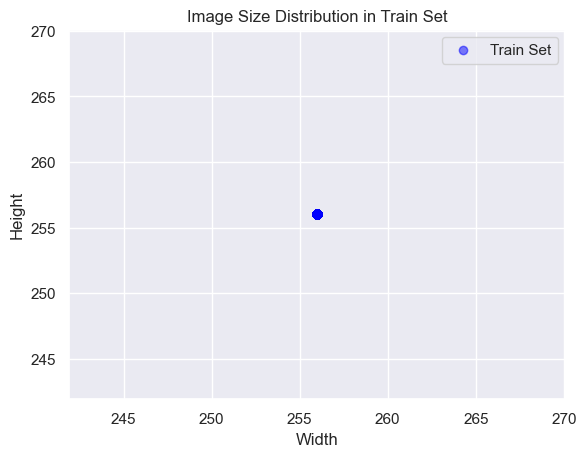

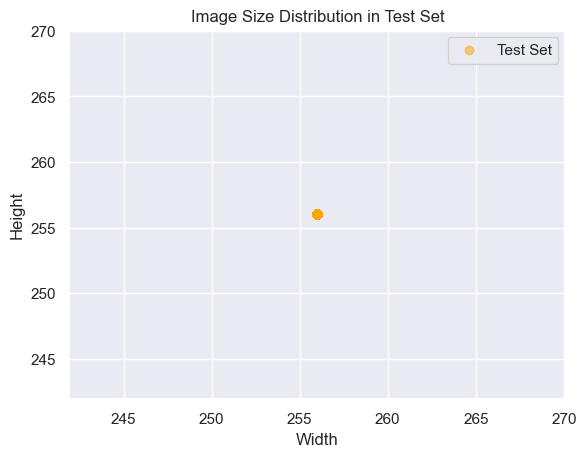

In [30]:
# Function to extract image sizes from the dataset
def get_image_sizes(dataset):
    return [img.shape[1:] for img, _ in dataset]

# Get image sizes for the train set
image_sizes_train = get_image_sizes(train_set)
widths_train = [size[1] for size in image_sizes_train]
heights_train = [size[0] for size in image_sizes_train]

# Plot the distribution of image sizes for the train set
plt.scatter(widths_train, heights_train, color='blue', label='Train Set', alpha=0.5)
plt.title('Image Size Distribution in Train Set')
plt.xlabel('Width')
plt.ylabel('Height')
plt.legend()
plt.show()

# Get image sizes for the test set
image_sizes_test = get_image_sizes(test_set)
widths_test = [size[1] for size in image_sizes_test]
heights_test = [size[0] for size in image_sizes_test]

# Plot the distribution of image sizes for the test set
plt.scatter(widths_test, heights_test, color='orange', label='Test Set', alpha=0.5)
plt.title('Image Size Distribution in Test Set')
plt.xlabel('Width')
plt.ylabel('Height')
plt.legend()
plt.show()


##### <b><I> Image Augmentation Visualization </I></b> 

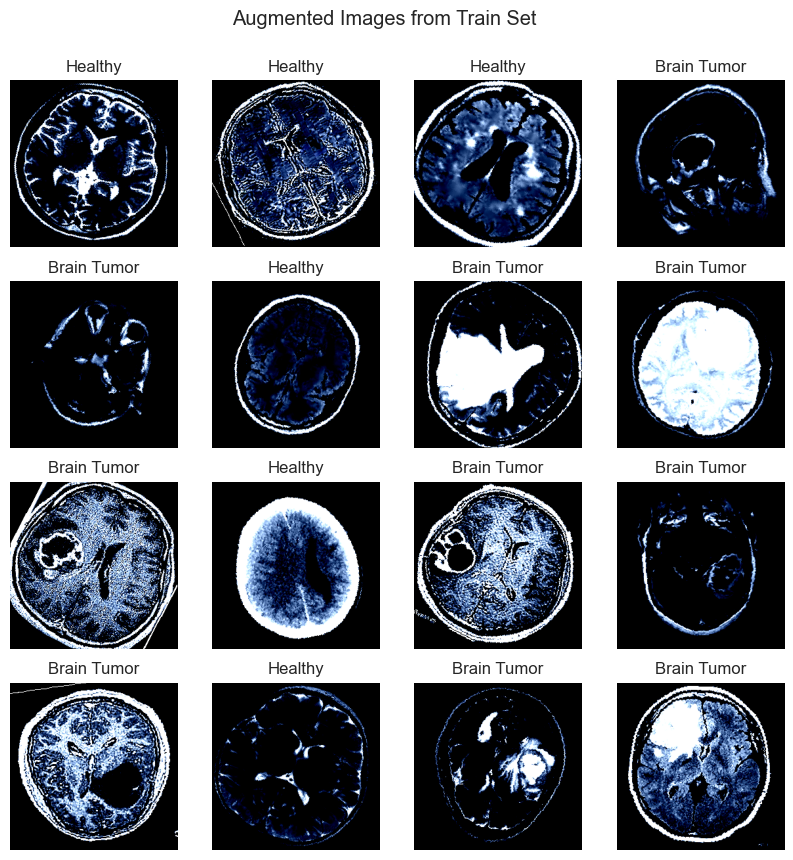

In [31]:
# Example of a simple augmentation
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
])

# Visualize some augmented images
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    img = augmentation(img)  # Apply augmentations
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle('Augmented Images from Train Set', y=0.95)
plt.show()


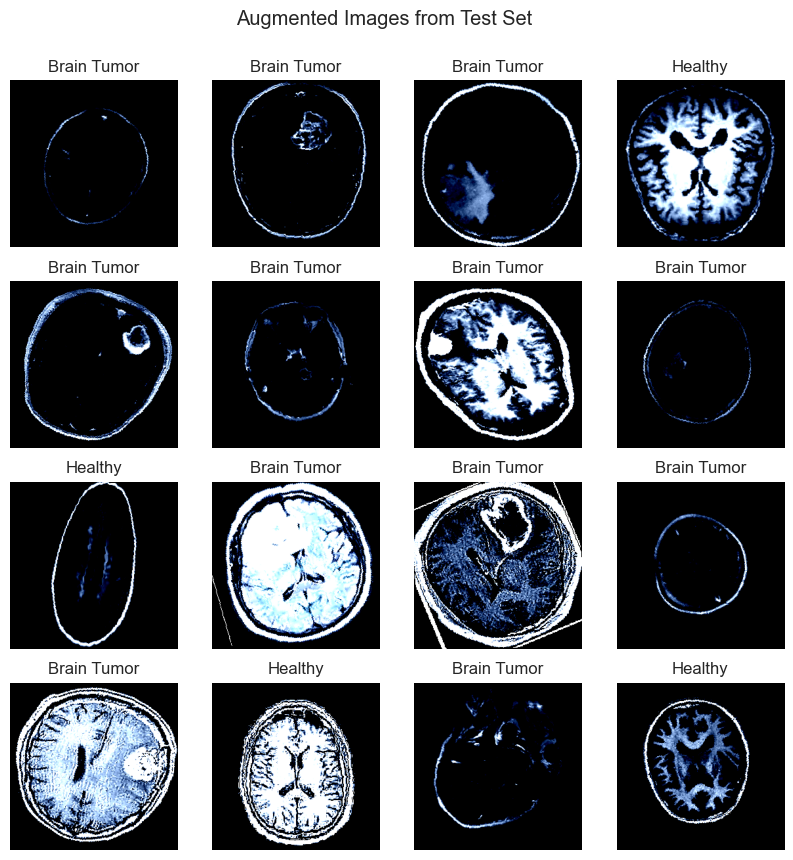

In [32]:
# Example of a simple augmentation
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
])

# Visualize some augmented images
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_set), size=(1,)).item()
    img, label = test_set[sample_idx]
    img = augmentation(img)  # Apply augmentations
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle('Augmented Images from Test Set', y=0.95)
plt.show()

## <b>03<span style='color:#e61227'>|</span> Model Development and Evaluation - Baseline Model </b>

#### <b><span style='color:#e61227'>|</span> Creating Dataloaders </b>

In [33]:
# Define the batch size for training and validation.
# This means the model will process 120 images at a time before updating the weights.
batch_size = 128

# Define the number of epochs for training.
# The model will go through the entire dataset 20 times during training.
num_epochs = 20

# Determine the device for computation.
# If a CUDA-enabled GPU is available, the code will use it for faster computations.
# Otherwise, it will default to using the CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [34]:
# Create a DataLoader for the training dataset
train_loader = torch.utils.data.DataLoader(
    train_set,                # The dataset to load (training data)
    batch_size=batch_size,    # Number of samples to process at once (batch size)
    shuffle=True,             # Shuffle the dataset at every epoch to reduce overfitting and improve generalization
    num_workers=2             # Number of subprocesses to use for data loading; using 2 workers can speed up data loading
)

# Create a DataLoader for the validation (test) dataset
test_loader = torch.utils.data.DataLoader(
    test_set,                  # The dataset to load (validation data)
    batch_size=batch_size,     # Number of samples to process at once (batch size)
    shuffle=True,              # Shuffle the validation data; while not strictly necessary, it can provide robustness in validation performance evaluation
    num_workers=2              # Number of subprocesses to use for data loading to improve loading speed
)



The DataLoader object contains multiple batches of data.

<b>Each batch contains two components:</b>

X: A tensor representing the input data (e.g., images).

y: A tensor representing the labels corresponding to the input data.


<b>The shapes are printed for the first batch of both the training data and the validation data:</b>

Shape of X: Could be something like (32, 3, 256, 256) for 64 images of size 256x256 with 3 channels (RGB).

Shape of y: Typically (64,) for the corresponding labels of those 64 images.

In [35]:
# Print shape for Training data and Validation data
for key, value in {'Training data': train_loader, "test data": test_loader}.items():
    # Iterate over a dictionary containing the DataLoaders for training and validation sets
    for X, y in value:
        # Get the first batch of data from the DataLoader
        print(f"{key}:")  # Print the key ('Training data' or 'test data')
        print(f"Shape of X : {X.shape}")  # Print the shape of the input data (features X)
        print(f"Shape of y: {y.shape} {y.dtype}\n")  # Print the shape and data type of the labels (y)
        break  # Break after printing the shape for the first batch only


Training data:
Shape of X : torch.Size([128, 3, 256, 256])
Shape of y: torch.Size([128]) torch.int64

test data:
Shape of X : torch.Size([128, 3, 256, 256])
Shape of y: torch.Size([128]) torch.int64



#### <b><span style='color:#e61227'>|</span> Define Output Feature Map for Convolution layer</b>

This function can be useful in determining the output size of a convolutional layer in a neural network, given the input dimensions and the convolutional layer's parameters.

### `findConv2dOutShape` Function

The function `findConv2dOutShape` is designed to calculate the output height and width of a 2D convolutional layer followed by an optional pooling layer, given the input dimensions (height and width) and the parameters of the convolution.

#### **Parameters:**

- **`hin`**: Height of the input.
- **`win`**: Width of the input.
- **`conv`**: A 2D convolutional layer (e.g., `torch.nn.Conv2d`).

    The convolution layer contains important parameters like kernel size, stride, padding, and dilation.

    **Key Variables from the `conv` Layer**:
    - **`kernel_size`**: The size of the convolutional filter (e.g., 3x3, 5x5).
    - **`stride`**: The step size of the filter as it moves across the input.
    - **`padding`**: The number of pixels added to the border of the input before convolution.
    - **`dilation`**: Controls the spacing between the kernel points.

- **`pool`**: The pooling layer size.  
  By default, this is set to `2` for a typical pooling operation (like `MaxPool2d`), but it can be set to `None` if there is no pooling layer.

#### **Input Image**:
The original image with dimensions `H_in` x `W_in`.

#### **Output Feature Map**:
After convolution, the feature map dimensions are `H_out` x `W_out`.



In [36]:
def findConv2dOutShape(hin, win, conv, pool=2):
    # Define a function to compute the output height and width of a 2D convolutional layer
    # hin: Input height
    # win: Input width
    # conv: Convolutional layer object (e.g., nn.Conv2d)
    # pool: Pooling size (default is 2, which is typical for max pooling)

    # Get convolutional layer parameters
    kernel_size = conv.kernel_size  # Size of the convolutional filter (e.g., (3, 3))
    stride = conv.stride            # Stride of the convolution (e.g., (1, 1))
    padding = conv.padding          # Padding applied to the input (e.g., (1, 1))
    dilation = conv.dilation        # Dilation of the convolution (spacing between kernel elements)

    # Calculate the output height after convolution
    hout = np.floor((hin + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) / stride[0] + 1)
    # Formula breakdown:
    # hin: Input height
    # + 2 * padding[0]: Add padding on top and bottom
    # - dilation[0] * (kernel_size[0] - 1): Account for dilation
    # - 1: Adjust for the filter's effect
    # / stride[0]: Divide by the stride to get the number of strides taken
    # + 1: Include the starting position in the count

    # Calculate the output width after convolution
    wout = np.floor((win + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) / stride[1] + 1)
    # Formula breakdown: Similar to height calculation but for width

    # If a pooling layer follows, adjust the output dimensions
    if pool:
        hout /= pool  # Divide output height by pooling size
        wout /= pool  # Divide output width by pooling size

    # Return the computed output dimensions as integers
    return int(hout), int(wout)


#### <b><span style='color:#e61227'>|</span> Define Architecture For CNN Model</b>

This section defines a Convolutional Neural Network (CNN) model named `CNN_BT` using PyTorch's `nn.Module`. The model is designed for image classification tasks, employing multiple convolutional layers followed by fully connected layers. Dropout is used for regularization, and the network outputs class probabilities using softmax.

#### 1. Network Initialization (`__init__` Method)

The `__init__` method sets up the layers of the model, including convolutional layers, fully connected layers, and other necessary components.

#### **Input Parameters**:
- `params`: A dictionary of hyperparameters used to define the model’s architecture. It contains:
  - `Cin, Hin, Win`: The number of input channels, height, and width of the input image.
  - `init_f`: The number of filters in the first convolutional layer.
  - `num_fc1`: The number of neurons in the first fully connected layer.
  - `num_classes`: The number of output classes for classification.
  - `dropout_rate`: The dropout rate used for regularization.

#### **Layers Defined**:
1. **Convolutional Layers**:
   - The model includes four convolutional layers with progressively increasing filter sizes. Each convolutional layer is responsible for extracting increasingly complex features from the input images.
   - The `findConv2dOutShape` function computes the dimensions of the output after each convolution, ensuring that the output size aligns with the input size for subsequent layers.

2. **Fully Connected Layers**:
   - Following the convolutional layers, the output is flattened and passed through two fully connected layers.
   - The first fully connected layer has a predefined number of neurons (`num_fc1`), while the second serves as the output layer, providing the classification scores for each class.


#### 2. Forward Pass (`forward` Method)

The forward pass describes the flow of data through the model, applying transformations as it moves through each layer.

#### **Process**:

1. **Convolutional Layers with ReLU and Max Pooling**:
   - Each convolutional layer is followed by a ReLU activation function, which introduces non-linearity, enabling the model to learn complex features. 
   - After each ReLU, max pooling is applied to downsample the feature maps, reducing their spatial dimensions while preserving the most important features.
2. **Flattening**:
   - After the final convolution and pooling, the output is flattened (converted to a 1D vector) to be fed into the fully connected layers.
3. **Fully Connected Layers**:
   - The flattened input is passed through the first fully connected layer (fc1) with ReLU activation, and dropout is applied to prevent overfitting.
4. **Output Layer**:
   - The second fully connected layer (fc2) produces the final output, which represents the log probabilities for each class using the softmax function.


In [37]:
# Define Architecture For CNN_BT Model
class CNN_BT(nn.Module):
    
    # Network Initialisation
    def __init__(self, params):
        # Call the constructor of the parent class nn.Module
        super(CNN_BT, self).__init__()
        
        # Extract parameters from the input dictionary
        Cin, Hin, Win = params["shape_in"]  # Input channels, height, and width of the input image
        init_f = params["initial_filters"]   # Initial number of filters for the first convolution layer
        num_fc1 = params["num_fc1"]          # Number of units in the first fully connected layer
        num_classes = params["num_classes"]   # Number of output classes for classification
        self.dropout_rate = params["dropout_rate"]  # Dropout rate for regularization
        
        # Convolution Layers
        # Define the first convolutional layer with 3x3 kernel
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        # Calculate the output height and width after conv1
        h, w = findConv2dOutShape(Hin, Win, self.conv1)
        
        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(init_f, 2 * init_f, kernel_size=3)
        # Calculate the output height and width after conv2
        h, w = findConv2dOutShape(h, w, self.conv2)
        
        # Define the third convolutional layer
        self.conv3 = nn.Conv2d(2 * init_f, 4 * init_f, kernel_size=3)
        # Calculate the output height and width after conv3
        h, w = findConv2dOutShape(h, w, self.conv3)
        
        # Define the fourth convolutional layer
        self.conv4 = nn.Conv2d(4 * init_f, 8 * init_f, kernel_size=3)
        # Calculate the output height and width after conv4
        h, w = findConv2dOutShape(h, w, self.conv4)
        
        # Compute the size of the flattened layer after convolutions
        self.num_flatten = h * w * 8 * init_f  # This will be the input size for the first fully connected layer
        # Define the first fully connected layer
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        # Define the second fully connected layer (output layer)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self, X):
        # Forward pass through the network
        # Apply ReLU activation and max pooling after each convolution
        X = F.relu(self.conv1(X))  # Apply conv1 and ReLU activation
        X = F.max_pool2d(X, 2, 2)  # Apply max pooling with a 2x2 window and a stride of 2
        X = F.relu(self.conv2(X))  # Apply conv2 and ReLU activation
        X = F.max_pool2d(X, 2, 2)  # Max pooling
        X = F.relu(self.conv3(X))  # Apply conv3 and ReLU activation
        X = F.max_pool2d(X, 2, 2)  # Max pooling
        X = F.relu(self.conv4(X))  # Apply conv4 and ReLU activation
        X = F.max_pool2d(X, 2, 2)  # Max pooling
        
        # Flatten the output for the fully connected layers
        X = X.view(-1, self.num_flatten)  # Reshape to (batch_size, num_flatten)
        X = F.relu(self.fc1(X))  # Apply the first fully connected layer and ReLU activation
        X = F.dropout(X, self.dropout_rate)  # Apply dropout for regularization
        X = self.fc2(X)  # Apply the second fully connected layer (output layer)
        
        # Return the output probabilities after applying softmax
        return F.log_softmax(X, dim=1)  # Logarithm of softmax for numerical stability


#### Convolutional Layers: 
- These layers extract important features from the input image. As the model progresses through the layers, the filters capture increasingly complex patterns, from edges in early layers to more abstract shapes in deeper layers.

#### Activation Function (ReLU): 
- The ReLU (Rectified Linear Unit) function introduces non-linearity to the model, enabling it to learn and model more complex data. It is applied after each convolutional layer to ensure that the network can learn a wide range of features.

#### Max Pooling: 
- Max pooling reduces the spatial size of the feature maps while retaining important features. This downsampling helps to make the model more efficient and less prone to overfitting by reducing the number of parameters.

#### Dropout: 
- Dropout is a regularization technique that deactivates random neurons during training, which helps the model generalize better by preventing it from becoming too reliant on specific neurons.

#### Softmax and Log-Softmax: 
- The final layer outputs class probabilities using the softmax function, which ensures the output values are interpretable as probabilities. Log-softmax is applied for numerical stability during training.

#### <b><span style='color:#e61227'>|</span> Define a dictionary containing parameters for the CNN model</b>

In [38]:
# Define a dictionary containing parameters for the CNN model
params = {
    "shape_in": (3, 256, 256),  # Input shape: 3 channels (RGB), height = 256, width = 256
    "initial_filters": 8,        # Number of filters in the first convolutional layer
    "num_fc1": 100,              # Number of neurons in the first fully connected layer
    "dropout_rate": 0.25,        # Dropout rate for regularization to prevent overfitting
    "num_classes": 2              # Number of output classes for classification (e.g., healthy and tumor)
}

#### <b><span style='color:#e61227'>|</span> Create an instance of the CNN model</b>

In [39]:
# Create an instance of the CNN_TUMOR class with the specified parameters
cnn_model = CNN_BT(params)

# Move the CNN model to the specified device (GPU or CPU)
model = cnn_model.to(device)
# This line transfers the model's parameters and buffers to the specified device, allowing it to utilize the GPU for faster computation if available.

#### <b><span style='color:#e61227'>|</span> Model Summary</b>

**Layer Type: The type of each layer (e.g., convolutional, fully connected).

**Output Shape: The shape of the output tensor after each layer.

**Param #: The number of trainable parameters in each layer.

**Total Parameters: The total number of parameters in the entire model.

**Trainable Parameters: The subset of parameters that will be updated during training.

In [40]:
model_summary = summary(cnn_model, input_size=(3, 256, 256), device=device.type)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            224
├─Conv2d: 1-2                            1,168
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                            1,254,500
├─Linear: 1-6                            202
Total params: 1,279,230
Trainable params: 1,279,230
Non-trainable params: 0


In [41]:
# Model Summary
print(cnn_model)

CNN_BT(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=12544, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)


#### <b><span style='color:#e61227'>|</span> Loss Function Definition  </b>

#### CrossEntropyLoss

CrossEntropyLoss is a commonly used loss function for classification problems in neural networks. It combines LogSoftmax and NLLLoss (negative log-likelihood loss) in a single class. CrossEntropyLoss is particularly useful for multi-class classification tasks.

In [42]:
criterion = nn.CrossEntropyLoss()

#### <b><span style='color:#e61227'>|</span> Optimiser Definition </b>

### Optimizer Initialization

The code initializes the **Adam optimizer** for training the CNN model, specifying a starting learning rate.

- **`optim.Adam`**: This is the Adam optimizer, an adaptive learning rate optimization algorithm.
    - It adjusts the learning rate based on estimates of the first and second moments of the gradients, making it efficient for large datasets.
    - Adam is widely used because it combines the benefits of **RMSProp** and **SGD with momentum**.
- **`cnn_model.parameters()`**: Passes the trainable parameters of the CNN model to the optimizer, allowing it to update them during training.
- **`lr=3e-4`**: This sets the learning rate to 0.0003, which controls how large the steps are that the optimizer takes to minimize the loss.

---

### Learning Rate Scheduler Setup

It also sets up a **learning rate scheduler** that will reduce the learning rate when the monitored metric (e.g., test loss) does not improve for a specified number of epochs.

1. **`ReduceLROnPlateau`**: A learning rate scheduler that monitors a metric (e.g., validation loss) and reduces the learning rate when the metric stops improving.
2. **`optimizer`**: The Adam optimizer is passed to the scheduler, allowing it to modify the learning rate dynamically.
3. **`mode='min'`**: The scheduler is set to minimize the monitored quantity (typically the loss). It reduces the learning rate when the loss stops decreasing.
4. **`factor=0.5`**: When the learning rate is reduced, it will be multiplied by this factor (in this case, halving the learning rate).
5. **`patience=20`**: The scheduler waits for 20 epochs without improvement before reducing the learning rate.

---

### Purpose

This setup helps the model converge more effectively and avoid getting stuck in local minima. By reducing the learning rate when necessary, the training process can continue with smaller updates, fine-tuning the model’s performance as it approaches an optimal solution.


In [43]:
# Create an Adam optimizer for the CNN model parameters with a learning rate of 0.0003 (3e-4)
optimizer = optim.Adam(cnn_model.parameters(), lr=3e-4)


# Initialize a learning rate scheduler without the verbose parameter
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, verbose=1)


c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


#### <b><span style='color:#e61227'>|</span> Loss and Metric </b>

In [44]:
# Initialize empty lists to store the loss values during training and testing
train_losses, test_losses = [], []  # `train_losses` will store the loss for each training epoch, and `test_losses` will store the loss for each testing/validation epoch

# Initialize empty lists to store accuracy values for training and testing
train_accs, test_accs = [], []  # `train_accs` will store the accuracy for each training epoch, and `test_accs` will store the accuracy for each testing/validation epoch

# Initialize an empty list to store all predicted values during testing
all_preds = []  # This list will hold all predictions made by the model during testing, useful for later evaluation (e.g., confusion matrix, precision, recall)

# Initialize an empty list to store all target values during testing
all_targets = []  # This list will hold all true target values (ground truth labels) during testing, used for comparison with `all_preds` to calculate evaluation metrics


#### <b><span style='color:#e61227'>|</span> Training Function </b>

In [45]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model in training mode (this enables certain layers like dropout to behave accordingly)
    model.train()
    
    correct = 0  # Variable to count how many predictions were correct
    total_loss = 0  # Variable to accumulate the total loss over the training epoch
    
    # Use tqdm to create a progress bar for the training loop
    # `tqdm(train_loader)` creates a progress bar, showing the progress of batches during training
    with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch}/{num_epochs} - Training") as tepoch:
        for data, target in tepoch:
            # Move data and targets to the specified device (GPU or CPU)
            data, target = data.to(device), target.to(device)
            
            # Zero the gradients to prevent accumulation from previous steps
            optimizer.zero_grad()
            
            # Forward pass: Compute the model's output for the current batch
            output = model(data)
            
            # Calculate the cross-entropy loss between the model's predictions and the true labels
            loss = criterion(output, target)
            
            # Backward pass: Compute gradients of the loss with respect to model parameters
            loss.backward()
            
            # Perform one optimization step (update the model's weights)
            optimizer.step()
            
            # Accumulate the loss over all batches in the epoch
            total_loss += loss.item()
            
            # Get the predicted class (with the highest score)
            pred = output.argmax(dim=1, keepdim=True)
            
            # Compare the predicted class to the actual class and count correct predictions
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # Update the progress bar description with the current loss value
            tepoch.set_postfix(loss=loss.item())
    
    # Calculate the average loss for the epoch
    avg_loss = total_loss / len(train_loader.dataset)
    
    # Calculate the accuracy for the epoch
    acc = 100. * correct / len(train_loader.dataset)
    
    # Append the average loss and accuracy for the current epoch to the respective tracking lists
    train_losses.append(avg_loss)
    train_accs.append(acc)
    
    # Print the summary of the training epoch
    print(f"\nTrain Epoch {epoch} - Average Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}%\n")


#### <b><span style='color:#e61227'>|</span> Testing Function </b>

In [46]:
def test(model, device, test_loader):
    # Set the model to evaluation mode
    model.eval()  # This disables dropout and batch normalization layers, which behave differently during evaluation

    test_loss = 0  # Variable to accumulate the total loss over the test set
    correct = 0  # Variable to count the correct predictions

    # Disable gradient computation for testing to save memory and computation
    with torch.no_grad():
        # Iterate through the test data loader
        for data, target in test_loader:
            # Move data and target labels to the specified device (CPU or GPU)
            data, target = data.to(device), target.to(device)
            
            # Forward pass: Compute the model's output for the current batch
            output = model(data)
            
            # Accumulate the loss for this batch
            test_loss += criterion(output, target).item()
            
            # Get the predicted class (the index of the maximum logit)
            pred = output.argmax(dim=1, keepdim=True)
            
            # Compare the predictions to the true labels and count the correct ones
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # Store predictions and targets for later evaluation (useful for metrics like confusion matrix)
            all_preds.extend(pred.cpu().numpy())  # Convert predictions to NumPy and store them
            all_targets.extend(target.cpu().numpy())  # Convert target labels to NumPy and store them

    # Calculate the average loss for the test set
    avg_loss = test_loss / len(test_loader.dataset)
    
    # Calculate the accuracy as a percentage
    accuracy = 100. * correct / len(test_loader.dataset)
    
    # Append the average loss and accuracy to the tracking lists
    test_losses.append(avg_loss)
    test_accs.append(accuracy)

    # Print the summary of the test epoch
    print(f"\nTest Epoch - Average Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%\n")


#### <b><span style='color:#e61227'>|</span> Model Training </b>

In [47]:
# Training loop with progress bar and status update after each epoch
for epoch in range(1, num_epochs + 1):
    # Train and test the model for the current epoch
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
# After the loop, you can add the final average summary if needed
avg_train_loss = sum(train_losses) / len(train_losses)
avg_test_loss = sum(test_losses) / len(test_losses)
avg_train_acc = sum(train_accs) / len(train_accs)
avg_test_acc = sum(test_accs) / len(test_accs)

print(f"Training Complete")
print(f"Average Training Loss: {avg_train_loss:.4f}, Average Training Accuracy: {avg_train_acc:.2f}%")
print(f"Average Testing Loss: {avg_test_loss:.4f}, Average Testing Accuracy: {avg_test_acc:.2f}%")


Epoch 1/20 - Training:   0%|          | 0/22 [00:00<?, ?batch/s]


Train Epoch 1 - Average Loss: 0.0052, Accuracy: 62.67%


Test Epoch - Average Loss: 0.0053, Accuracy: 64.44%



Epoch 2/20 - Training:   0%|          | 0/22 [00:00<?, ?batch/s]


Train Epoch 2 - Average Loss: 0.0046, Accuracy: 72.13%


Test Epoch - Average Loss: 0.0046, Accuracy: 73.48%



Epoch 3/20 - Training:   0%|          | 0/22 [00:00<?, ?batch/s]


Train Epoch 3 - Average Loss: 0.0040, Accuracy: 76.84%


Test Epoch - Average Loss: 0.0037, Accuracy: 78.72%



Epoch 4/20 - Training:   0%|          | 0/22 [00:00<?, ?batch/s]


Train Epoch 4 - Average Loss: 0.0036, Accuracy: 80.07%


Test Epoch - Average Loss: 0.0035, Accuracy: 81.42%



Epoch 5/20 - Training:   0%|          | 0/22 [00:00<?, ?batch/s]


Train Epoch 5 - Average Loss: 0.0032, Accuracy: 81.73%


Test Epoch - Average Loss: 0.0037, Accuracy: 79.73%



Epoch 6/20 - Training:   0%|          | 0/22 [00:00<?, ?batch/s]


Train Epoch 6 - Average Loss: 0.0032, Accuracy: 82.31%


Test Epoch - Average Loss: 0.0033, Accuracy: 84.21%



Epoch 7/20 - Training:   0%|          | 0/22 [00:00<?, ?batch/s]


Train Epoch 7 - Average Loss: 0.0030, Accuracy: 83.33%


Test Epoch - Average Loss: 0.0029, Accuracy: 84.54%



Epoch 8/20 - Training:   0%|          | 0/22 [00:00<?, ?batch/s]


Train Epoch 8 - Average Loss: 0.0028, Accuracy: 84.60%


Test Epoch - Average Loss: 0.0030, Accuracy: 84.04%



Epoch 9/20 - Training:   0%|          | 0/22 [00:00<?, ?batch/s]


Train Epoch 9 - Average Loss: 0.0026, Accuracy: 85.61%


Test Epoch - Average Loss: 0.0026, Accuracy: 85.47%



Epoch 10/20 - Training:   0%|          | 0/22 [00:00<?, ?batch/s]


Train Epoch 10 - Average Loss: 0.0025, Accuracy: 86.52%


Test Epoch - Average Loss: 0.0026, Accuracy: 87.16%



Epoch 11/20 - Training:   0%|          | 0/22 [00:00<?, ?batch/s]


Train Epoch 11 - Average Loss: 0.0025, Accuracy: 87.02%


Test Epoch - Average Loss: 0.0024, Accuracy: 88.18%



Epoch 12/20 - Training:   0%|          | 0/22 [00:00<?, ?batch/s]


Train Epoch 12 - Average Loss: 0.0024, Accuracy: 87.75%


Test Epoch - Average Loss: 0.0034, Accuracy: 81.76%



Epoch 13/20 - Training:   0%|          | 0/22 [00:00<?, ?batch/s]


Train Epoch 13 - Average Loss: 0.0026, Accuracy: 85.97%


Test Epoch - Average Loss: 0.0029, Accuracy: 84.46%



Epoch 14/20 - Training:   0%|          | 0/22 [00:00<?, ?batch/s]


Train Epoch 14 - Average Loss: 0.0023, Accuracy: 88.11%


Test Epoch - Average Loss: 0.0022, Accuracy: 89.19%



Epoch 15/20 - Training:   0%|          | 0/22 [00:00<?, ?batch/s]


Train Epoch 15 - Average Loss: 0.0022, Accuracy: 89.05%


Test Epoch - Average Loss: 0.0023, Accuracy: 87.92%



Epoch 16/20 - Training:   0%|          | 0/22 [00:00<?, ?batch/s]


Train Epoch 16 - Average Loss: 0.0022, Accuracy: 88.51%


Test Epoch - Average Loss: 0.0021, Accuracy: 90.46%



Epoch 17/20 - Training:   0%|          | 0/22 [00:00<?, ?batch/s]


Train Epoch 17 - Average Loss: 0.0022, Accuracy: 88.40%


Test Epoch - Average Loss: 0.0021, Accuracy: 89.44%



Epoch 18/20 - Training:   0%|          | 0/22 [00:00<?, ?batch/s]


Train Epoch 18 - Average Loss: 0.0021, Accuracy: 89.31%


Test Epoch - Average Loss: 0.0021, Accuracy: 90.12%



Epoch 19/20 - Training:   0%|          | 0/22 [00:00<?, ?batch/s]


Train Epoch 19 - Average Loss: 0.0020, Accuracy: 89.78%


Test Epoch - Average Loss: 0.0019, Accuracy: 91.05%



Epoch 20/20 - Training:   0%|          | 0/22 [00:00<?, ?batch/s]


Train Epoch 20 - Average Loss: 0.0019, Accuracy: 90.87%


Test Epoch - Average Loss: 0.0021, Accuracy: 89.27%

Training Complete
Average Training Loss: 0.0028, Average Training Accuracy: 84.03%
Average Testing Loss: 0.0029, Average Testing Accuracy: 84.25%


#### <b><span style='color:#e61227'>|</span> Visualisation </b>

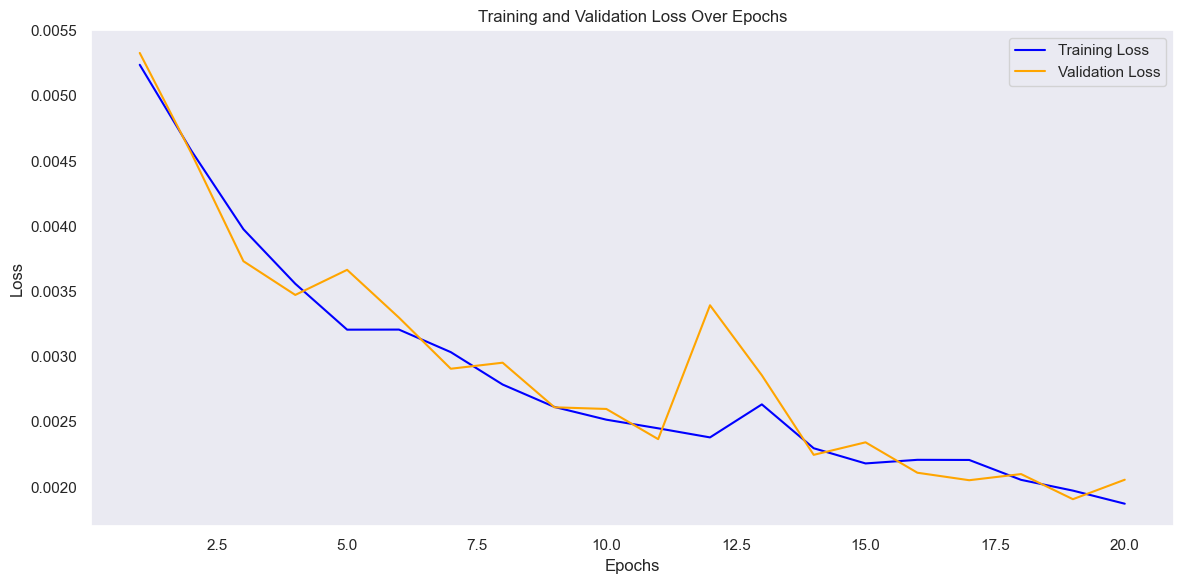

In [48]:
# Number of epochs from your parameters
epochs = num_epochs  # Use num_epochs instead of params_train["epochs"]

# Create a new figure for the plots
plt.figure(figsize=(12, 6))

# Plot training loss
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='blue')

# Plot validation (testing) loss
plt.plot(range(1, epochs + 1), test_losses, label='Validation Loss', color='orange')

# Add titles and labels
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend to distinguish between training and validation loss
plt.legend()

# Optionally add gridlines for better readability
plt.grid()

# Show the plot
plt.tight_layout()  # Adjust layout to make it look nice
plt.show()


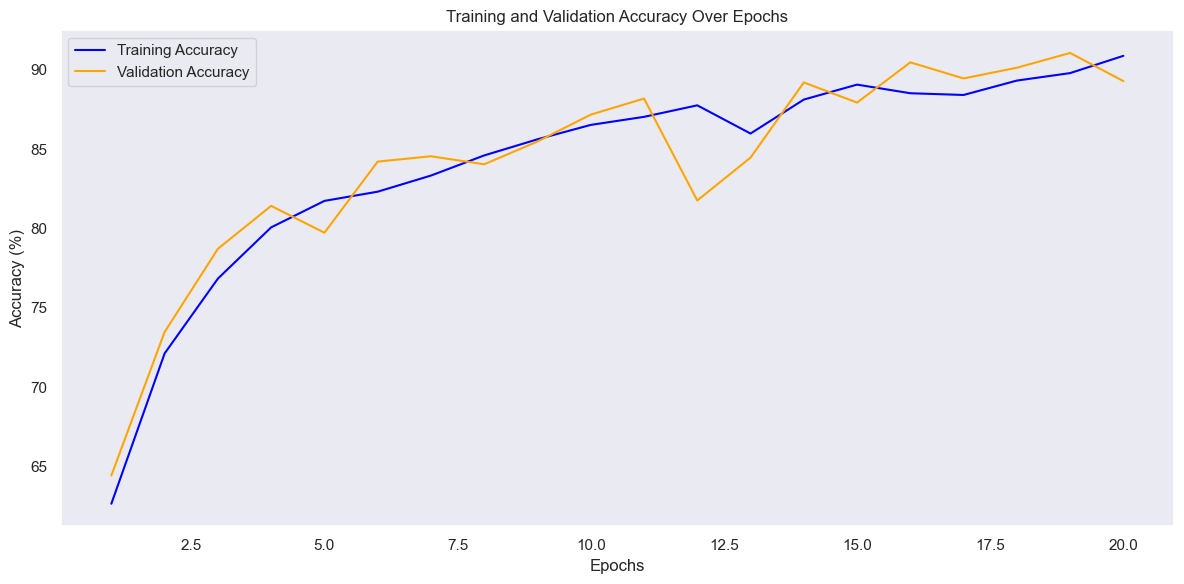

In [49]:
# Number of epochs from your parameters
epochs = num_epochs  # Use num_epochs instead of params_train["epochs"]

# Create a new figure for the accuracy plots
plt.figure(figsize=(12, 6))

# Plot training accuracy
plt.plot(range(1, epochs + 1), train_accs, label='Training Accuracy', color='blue')

# Plot validation (testing) accuracy
plt.plot(range(1, epochs + 1), test_accs, label='Validation Accuracy', color='orange')

# Add titles and labels
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')

# Add a legend to distinguish between training and validation accuracy
plt.legend()

# Optionally add gridlines for better readability
plt.grid()

# Show the plot
plt.tight_layout()  # Adjust layout to make it look nice
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


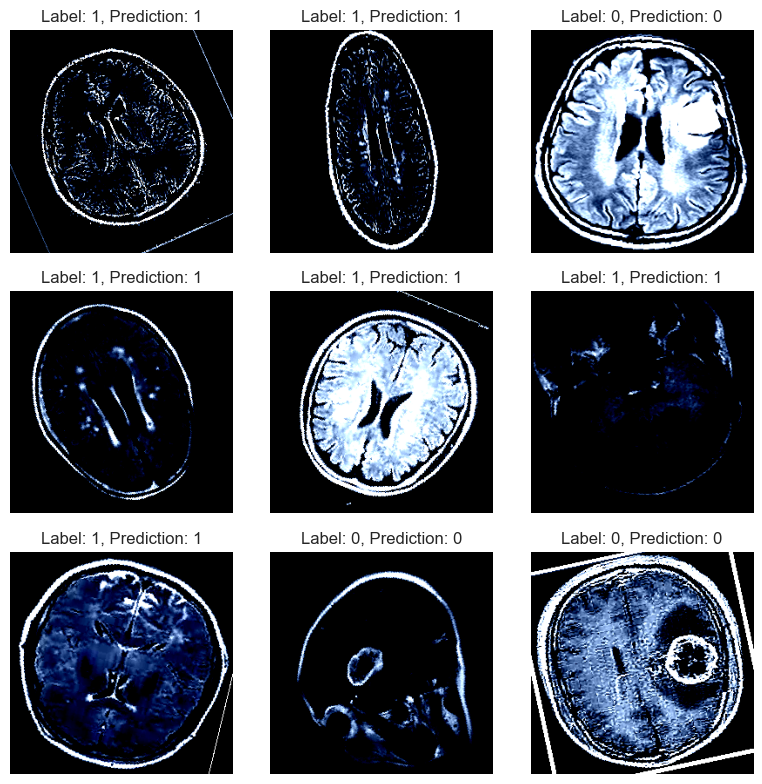

In [50]:
# Visualize some sample images and predictions
samples, labels = next(iter(test_loader))
samples, labels = samples.to(device), labels.to(device)

# Get model predictions
outputs = model(samples)
_, preds = torch.max(outputs, 1)

# Convert samples to numpy for visualization
samples = samples.cpu().numpy()

# Create a grid of 3x3 images for visualization
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.ravel()):
    # Rearrange from (C, H, W) to (H, W, C) and denormalize the image
    img = samples[i].transpose((1, 2, 0))
    
    # Display the image
    ax.imshow(img, cmap='gray' if img.shape[2] == 1 else None)
    
    # Set title with label and prediction
    ax.set_title(f'Label: {labels[i].item()}, Prediction: {preds[i].item()}')
    
    # Remove axes
    ax.axis('off')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


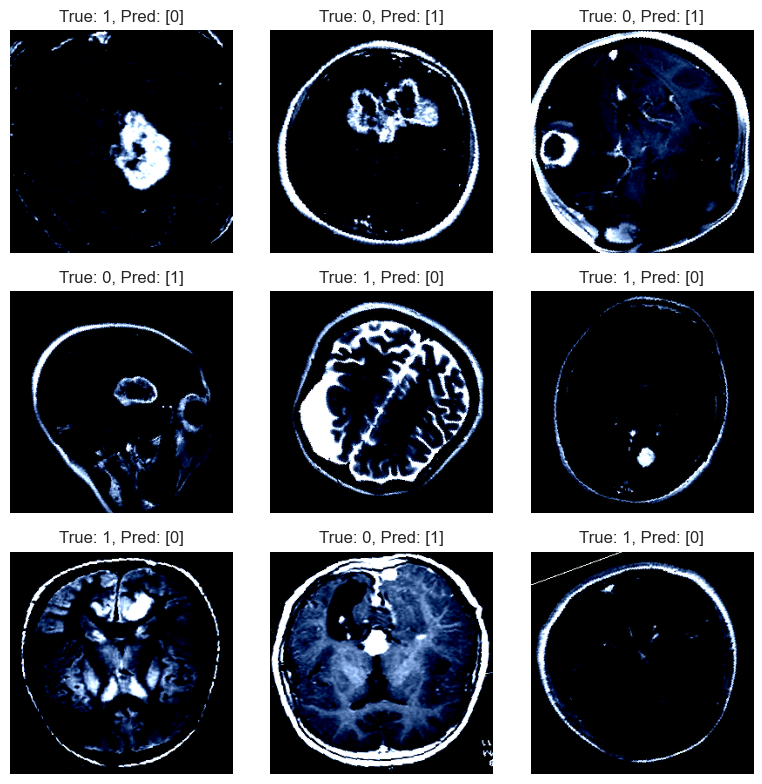

In [51]:
# Visualize incorrect predictions
# all_preds: list of predicted labels
# all_labels: list of actual labels

incorrect = [i for i in range(len(all_preds)) if all_preds[i] != all_targets[i]]

# Create a figure for displaying 3x3 grid of incorrect predictions
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

# Loop through the first 9 incorrect predictions and plot them
for i, ax in enumerate(axes.ravel()):
    if i < len(incorrect):  # Make sure we don't exceed available incorrect samples
        idx = incorrect[i]
        
        # Get the image and its true and predicted labels
        image, _ = test_loader.dataset[idx]
        true_label = all_targets[idx]
        pred_label = all_preds[idx]
        
        # Display the image
        ax.imshow(image.permute(1, 2, 0).cpu().numpy(), cmap='gray' if image.shape[0] == 1 else None)
        
        # Set the title with true and predicted labels
        ax.set_title(f'True: {true_label}, Pred: {pred_label}')
        
        # Remove the axis
        ax.axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


#### <b><span style='color:#e61227'>|</span> Evaluation </b>

In [52]:
# Define function for obtaining true and predicted labels from the validation set
def Ture_and_Pred(test_loader, model):
    i = 0  # Initialize a counter (not used further)
    y_true = []  # List to store true labels
    y_pred = []  # List to store predicted labels

    # Loop through the validation DataLoader
    for images, labels in test_loader:
        images = images.to(device)  # Move images to the appropriate device (GPU/CPU)
        labels = labels.numpy()  # Convert labels to a NumPy array for easier manipulation
        outputs = model(images)  # Get model predictions for the input images
        _, pred = torch.max(outputs.data, 1)  # Get the index of the maximum score (predicted class)
        pred = pred.detach().cpu().numpy()  # Move predictions to CPU and convert to NumPy array
        
        # Append the true labels and predicted labels to their respective lists
        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)
    
    return y_true, y_pred  # Return the lists of true and predicted labels


# Check confusion matrix for error analysis
y_true, y_pred = Ture_and_Pred(test_loader, model)  # Get true and predicted labels using the function

# Print classification report to evaluate model performance
print(classification_report(y_true, y_pred), '\n\n')

# Calculate confusion matrix for further error analysis
cm = confusion_matrix(y_true, y_pred)  # Create the confusion matrix from true and predicted labels

              precision    recall  f1-score   support

         0.0       0.95      0.89      0.92       669
         1.0       0.87      0.93      0.90       515

    accuracy                           0.91      1184
   macro avg       0.91      0.91      0.91      1184
weighted avg       0.91      0.91      0.91      1184
 




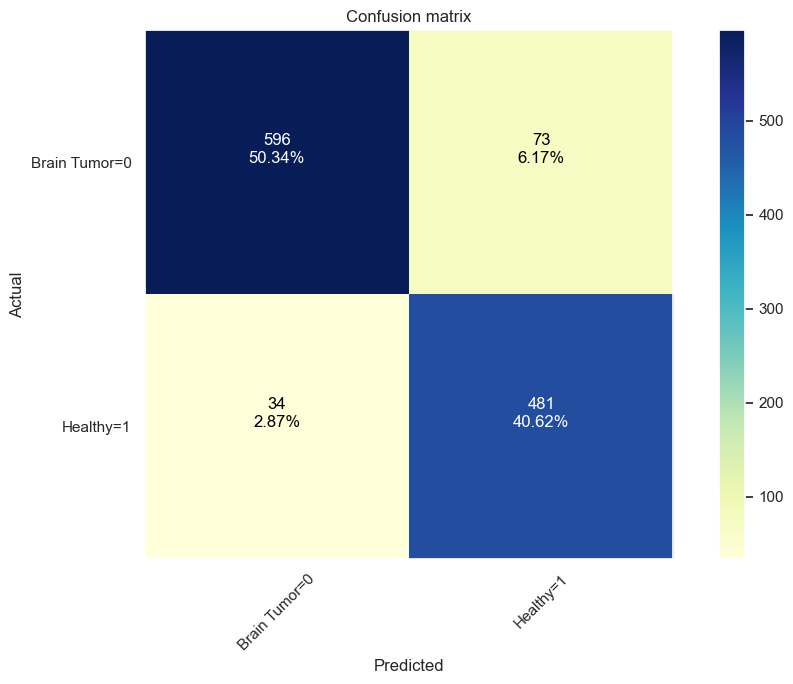

In [53]:
# Confusion Matrix Plotting Function
def show_confusion_matrix(cm, CLA_label, title='Confusion matrix', cmap=plt.cm.YlGnBu):
    # Define a function to plot a confusion matrix
    # cm: confusion matrix
    # CLA_label: dictionary mapping class indices to class names
    # title: title of the plot
    # cmap: color map for the plot

    plt.figure(figsize=(10, 7))  # Create a new figure with a specified size (10x7 inches)
    plt.grid(False)  # Disable the grid for better visual clarity
    plt.imshow(cm, interpolation='nearest', cmap=cmap)  # Display the confusion matrix as an image with the specified colormap
    plt.title(title)  # Set the title of the plot
    plt.colorbar()  # Add a color bar to indicate the scale of values

    tick_marks = np.arange(len(CLA_label))  # Create an array of tick marks for the class labels
    # Set x-axis ticks and labels with class names, rotated 45 degrees for better readability
    plt.xticks(tick_marks, [f"{value}={key}" for key, value in CLA_label.items()], rotation=45)
    # Set y-axis ticks and labels with class names
    plt.yticks(tick_marks, [f"{value}={key}" for key, value in CLA_label.items()])

    thresh = cm.max() / 2.  # Determine the threshold for text color based on the maximum value in the confusion matrix
    # Iterate over each cell in the confusion matrix
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # Place text in each cell showing the number and percentage of predictions
        plt.text(j, i, f"{cm[i, j]}\n{cm[i, j] / np.sum(cm) * 100:.2f}%", 
                 horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")  # Choose text color based on the threshold

    plt.ylabel('Actual')  # Label for the y-axis
    plt.xlabel('Predicted')  # Label for the x-axis
    plt.tight_layout()  # Adjust the layout to fit everything nicely
    plt.show()  # Display the plot

# Call the function to show the confusion matrix
show_confusion_matrix(cm, CLA_label)


#### <b><span style='color:#e61227'>|</span> Save Model</b>

In [54]:
torch.save(cnn_model.state_dict(), 'model_cnn_baseline.pth')

## <b>04<span style='color:#e61227'>|</span> Explainability </b>

#### <b><span style='color:#e61227'>|</span> Grad-CAM</b>

Grad-CAM (Gradient-weighted Class Activation Mapping) is a popular technique used to provide visual explanations for the predictions made by convolutional neural networks (CNNs) on image classification tasks. It highlights the regions of the input image that are most important for the model's decision-making process.

c:\Users\LENOVO\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


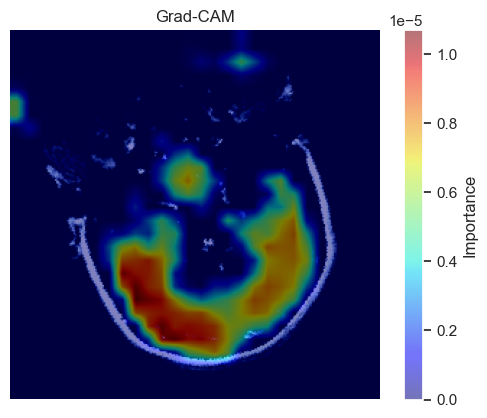

In [55]:
# Grad-CAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activation = None

        # Hook for gradients and activations
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activation = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, input_image, class_idx=None):
        input_image = input_image.to(device).unsqueeze(0)

        # Forward pass
        output = self.model(input_image)
        if class_idx is None:
            class_idx = output.argmax().item()

        # Zero the gradients
        self.model.zero_grad()

        # Backward pass
        output[:, class_idx].backward()

        # Get the weights of the gradients
        weights = self.gradients.mean(dim=[2, 3], keepdim=True)
        
        # Get the weighted combination of activations
        grad_cam = torch.sum(weights * self.activation, dim=1).squeeze(0).cpu().detach().numpy()

        # Apply ReLU and resize
        grad_cam = np.maximum(grad_cam, 0)
        grad_cam = cv2.resize(grad_cam, (input_image.shape[-1], input_image.shape[-2]))

        return grad_cam

def plot_grad_cam(image, grad_cam, title="Grad-CAM"):
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())  # Display the original image
    plt.imshow(grad_cam, cmap='jet', alpha=0.5)  # Overlay the Grad-CAM heatmap with transparency
    plt.colorbar(label="Importance")  # Add color bar to show values of the heatmap
    plt.title(title)
    plt.axis('off')
    plt.show()

# Example of using Grad-CAM
model.eval()
target_layer = model.conv4  # Use the final convolutional layer
grad_cam = GradCAM(model, target_layer)

# Test with an example image from your test_loader
batch = next(iter(test_loader))
images, _ = batch
input_image = images[1]

grad_cam_output = grad_cam(input_image)
plot_grad_cam(input_image, grad_cam_output)


#### <b><span style='color:#e61227'>|</span> Saliency Map</b>

A Saliency Map is a widely-used technique in image explainability that helps visualize which parts of an image influence a model’s prediction the most. It highlights the areas in an image that the neural network considers important for making a decision. 

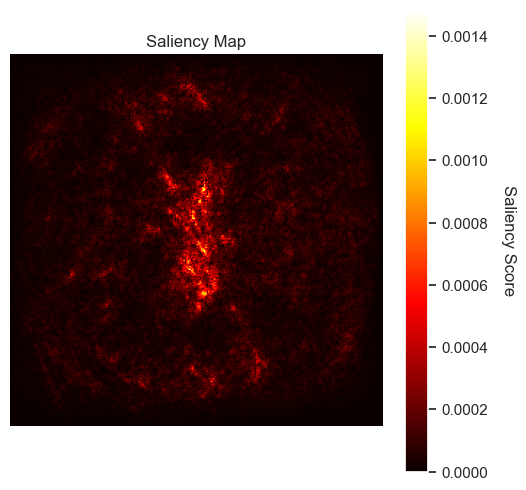

In [56]:
def generate_saliency(model, input_image, target_class=None):
    input_image = input_image.unsqueeze(0).to(device)
    input_image.requires_grad_()

    # Forward pass
    output = model(input_image)
    
    # Use the top class if not specified
    if target_class is None:
        target_class = output.argmax(dim=1).item()

    # Zero gradients
    model.zero_grad()

    # Backward pass
    output[:, target_class].backward()

    # Get the saliency map
    saliency, _ = torch.max(input_image.grad.data.abs(), dim=1)
    return saliency[0].cpu().detach().numpy()

# Example of saliency map
saliency_map = generate_saliency(model, images[0])

# Plot the saliency map with a color bar
plt.figure(figsize=(6, 6))
img = plt.imshow(saliency_map, cmap='hot')

# Add color bar to explain the color values
cbar = plt.colorbar(img)
cbar.set_label('Saliency Score', rotation=270, labelpad=20)

plt.title("Saliency Map")
plt.axis('off')
plt.show()


#### <b><span style='color:#e61227'>|</span> Integrated Gradients Plot</b>

Integrated Gradients (IG) is an explainability technique that provides insight into the contribution of input features (pixels, in the case of images) toward a model’s predictions. It addresses some of the limitations of traditional gradient-based methods like saliency maps by offering more reliable and less noisy attributions.

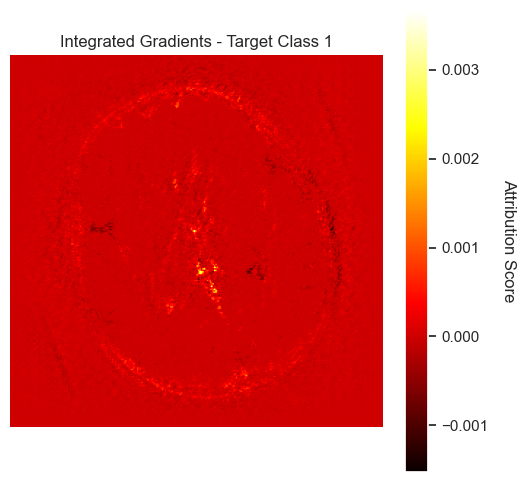

In [57]:

def plot_integrated_gradients(model, input_image, target_class=None):
    model.eval()
    
    # Initialize IntegratedGradients
    ig = IntegratedGradients(model)

    # Prepare the input image and baseline
    input_image = input_image.unsqueeze(0).to(device)  # Add batch dimension and move to device
    baseline = torch.zeros_like(input_image).to(device)  # Baseline is a black image

    # Get the model's prediction if target_class is not specified
    if target_class is None:
        with torch.no_grad():
            output = model(input_image)
            target_class = output.argmax(dim=1).item()  # Choose the class with highest probability

    # Compute attributions for the specified target class
    attributions = ig.attribute(input_image, baseline, target=target_class)
    
    # Convert to numpy for plotting
    attributions = attributions.squeeze(0).cpu().detach().numpy().sum(axis=0)
    
    # Plot the attributions with a color bar
    plt.figure(figsize=(6, 6))
    img = plt.imshow(attributions, cmap='hot')

    # Add a color bar to explain the color scale
    cbar = plt.colorbar(img)
    cbar.set_label('Attribution Score', rotation=270, labelpad=20)

    plt.title(f"Integrated Gradients - Target Class {target_class}")
    plt.axis('off')
    plt.show()

# Example usage with an image from your test loader
batch = next(iter(test_loader))
images, _ = batch
plot_integrated_gradients(model, images[0])


#### <b><span style='color:#e61227'>|</span> Occulusion Sensitivity Plot</b>

An Occlusion Sensitivity Plot is a method used in image explainability to understand the importance of different regions of an image by systematically occluding (covering) parts of the image and observing how the model's prediction changes. This approach helps identify which areas of the image are most critical for the model’s decision-making process.

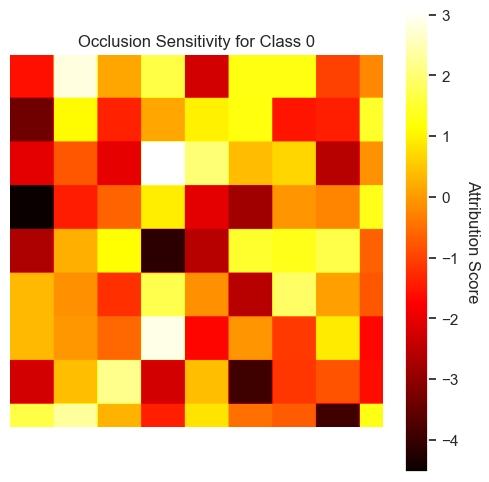

In [58]:


def plot_occlusion_sensitivity(model, input_image, target_class=0):
    model.eval()
    occlusion = Occlusion(model)

    input_image = input_image.unsqueeze(0).to(device)

    # Sliding window occlusion
    attributions = occlusion.attribute(
        input_image,
        sliding_window_shapes=(3, 30, 30),  # Larger window size
        strides=(3, 30, 30),  # Increased stride
        target=target_class  # Specify target class for occlusion sensitivity
    )

    # Process attributions to be displayed
    attributions = attributions.squeeze(0).cpu().detach().numpy().sum(axis=0)

    # Plot the attributions with a color bar
    plt.figure(figsize=(6, 6))
    plt.imshow(attributions, cmap='hot')
    plt.title(f"Occlusion Sensitivity for Class {target_class}")
    plt.axis('off')

    # Add color bar to explain the color scale
    cbar = plt.colorbar()
    cbar.set_label('Attribution Score', rotation=270, labelpad=15)

    plt.show()

# Example of using Occlusion Sensitivity with target class 0 and color bar
plot_occlusion_sensitivity(model, images[0], target_class=0)


#### <b><span style='color:#e61227'>|</span> LIME</b>

LIME (Local Interpretable Model-agnostic Explanations) is designed to provide explanations locally, meaning it explains a model’s prediction for a specific image, rather than offering global insights into the overall model behavior. This is especially useful when you want to understand why the model made a certain decision for a particular input.

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


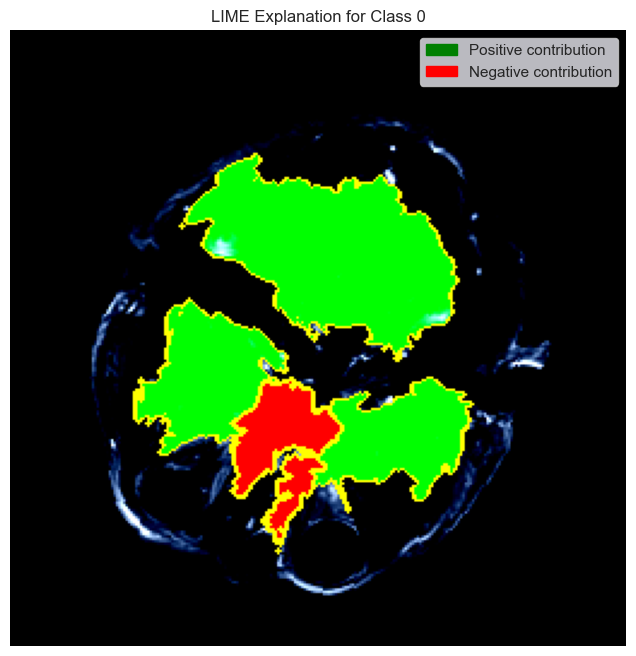

In [59]:
# Function to pass image through the PyTorch model and get probabilities
def predict_fn(images):
    model.eval()
    # Convert images from numpy to torch tensors
    tensor_images = torch.stack([transforms.ToTensor()(image) for image in images]).to(device)
    with torch.no_grad():
        outputs = model(tensor_images)
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
    return probabilities

# Initialize LIME explainer for images
explainer = lime_image.LimeImageExplainer()

# Test with an example image from your test_loader
batch = next(iter(test_loader))
images, _ = batch
input_image = images[0].permute(1, 2, 0).cpu().numpy()  # Convert to NumPy and reshape

# Generate explanation for the input image
explanation = explainer.explain_instance(
    input_image,  # Input image in NumPy format
    predict_fn,   # Prediction function
    top_labels=1,  # Explain the top predicted class
    hide_color=0,  # Pixels to hide
    num_samples=1000  # Number of perturbations
)

# Get the explanation for the top class (most probable class)
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],  # Get explanation for top predicted label
    positive_only=False, 
    num_features=5,  # Number of superpixels to highlight
    hide_rest=False
)

# Plot the original image with LIME explanation
plt.figure(figsize=(8, 8))
plt.imshow(mark_boundaries(temp, mask))

# Add labels for positive and negative contributions
green_patch = mpatches.Patch(color='green', label='Positive contribution')
red_patch = mpatches.Patch(color='red', label='Negative contribution')

# Add the legend to explain the color coding
plt.legend(handles=[green_patch, red_patch], loc='upper right')
plt.title(f"LIME Explanation for Class {explanation.top_labels[0]}")
plt.axis('off')
plt.show()
